In [26]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support

In [27]:
# getting the spectrum to analyze
hdu = fits.open('data/co2_01.H.2335.ell.1d.fits')  

In [28]:
spectrum_header = hdu[1].header

In [29]:
spectrum_header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -64 / Number of bits per data pixel                  
NAXIS   =                    1 / Number of data axes                            
NAXIS1  =                 2314 /Number of positions along axis 1                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
CRVAL1  =              14495.0 /                                                
CDELT1  =              1.62690 /                                                
CRPIX1  =              1.00000 /                                                
CTYPE1  = 'LINEAR  '           /                                                
EXPTIME =              7157.57 / Total exposure time (seconds)                  
FILNM   = 'co2_01.H.2335.2d.fits' / name of file                                
MSKNM   = 'co2_01  '        

In [30]:
start_wavelength = spectrum_header['CRVAL1']
delta_wavelength = spectrum_header['CDELT1']
length_of_array = spectrum_header['NAXIS1']

#generating the wavelength array for the spectrum
wavelength = start_wavelength + np.arange(0, length_of_array, 1) * delta_wavelength

#getting the spectrum data

spectrum = hdu[1].data

In [31]:
from specutils import Spectrum1D

In [32]:
#to use specutils we need to provide it with astropy quantity objects 

#making the astropy quantity wavelength
lamb = wavelength * u.AA #units of Angstroms 

#manking an astropy unit of flux
flux = spectrum * u.Unit('erg cm-2 s-1 AA-1')

#making the specutils spectrum object
spec = Spectrum1D(spectral_axis=lamb, flux=flux) 

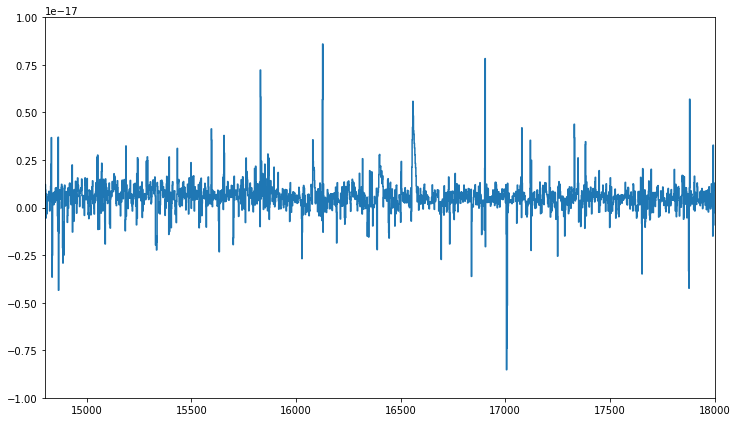

In [37]:
fig, ax = plt.subplots(figsize = (12, 7))  
ax.step(spec.spectral_axis, spec.flux) 
ax.set_ylim(-1e-17, 1e-17)
ax.set_xlim(14800, 18000)
plt.show()

## Specutils Zoom-in and Equivalent Width Calculation

In [39]:
from specutils import SpectralRegion
from specutils.analysis import equivalent_width


#Look for an emission feature in the above image
# take a range of +/- 50 angstroms around the line center
#then use the Spectral Region to zoom in near that window

emission_line_region = SpectralRegion(16250 * u.AA, 16500* u.AA)

equivalent_width(spec, regions = emission_line_region)

<Quantity 248.9157 Angstrom>

In [41]:
from specutils.manipulation import extract_region

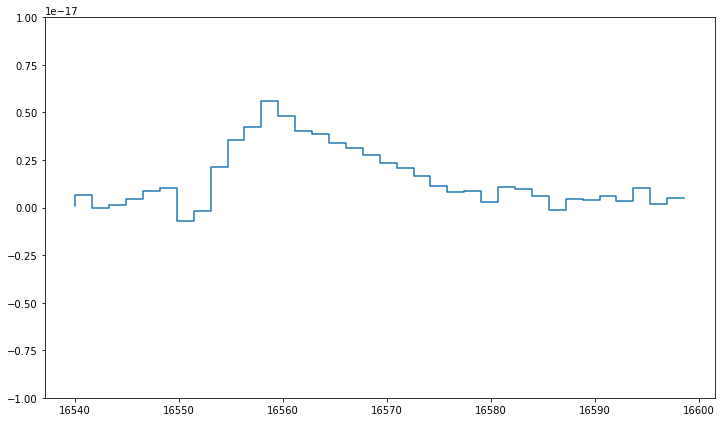

In [45]:
#Here you can play around with the spectrum sub-window
#the spectrum sub window
region = SpectralRegion(16540 * u.AA, 16600* u.AA)

#the sub spectral region
sub_spectrum = extract_region(spec, region)

fig, ax = plt.subplots(figsize = (12, 7))  
ax.step(sub_spectrum.spectral_axis, sub_spectrum.flux) 
ax.set_ylim(-1e-17, 1e-17)
plt.show()

# Specutils Analysis

In [46]:
from specutils.analysis import snr
from specutils.analysis import snr_derived
from specutils.analysis import line_flux
from specutils.analysis import centroid
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi

In [50]:
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models

In [51]:
np.random.seed(42)
spectral_axis = np.linspace(11., 1., 200) * u.GHz
spectral_model = models.Gaussian1D(amplitude=5*(2*np.pi*0.8**2)**-0.5*u.Jy, mean=5*u.GHz, stddev=0.8*u.GHz)
flux = spectral_model(spectral_axis)
flux += np.random.normal(0., 0.05, spectral_axis.shape) * u.Jy
uncertainty = StdDevUncertainty(0.2*np.ones(flux.shape)*u.Jy)
noisy_gaussian = Spectrum1D(spectral_axis=spectral_axis, flux=flux, uncertainty=uncertainty)

In [54]:
# Using you emission line region you can do all sorts of cool analysis of it

#Getting the signal to noise ratio

print(f'The SNR is: {snr(noisy_gaussian):.3f}')

#getting the flux of the line

print(f'The SNR is: {line_flux(noisy_gaussian):.3f}')

#getting the center of the line
print(f'The center of the line is: {centroid(noisy_gaussian, SpectralRegion(7*u.GHz, 3*u.GHz)):.3f}')

#getting different line width information
print(f'Gaussian Sigma is: {gaussian_sigma_width(noisy_gaussian):.3f}')
print(f'Gaussian FWHM: {gaussian_fwhm(noisy_gaussian):.3f}')
print(f'FWHM is: {fwhm(noisy_gaussian):.3f}')
print(f'FWZI is: {fwzi(noisy_gaussian):.3f}')

The SNR is: 2.477
The SNR is: 4.980 GHz Jy
The center of the line is: 4.999 GHz
Gaussian Sigma is: 0.741 GHz
Gaussian FWHM: 1.744 GHz
FWHM is: 1.860 GHz
FWZI is: 95.000 GHz


# Specutils Line Fitting

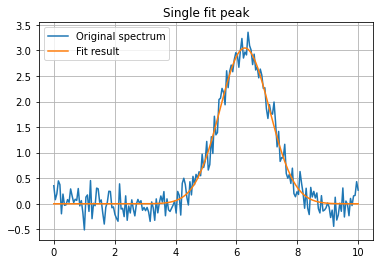

In [55]:
from astropy.modeling import models
from specutils.fitting import fit_lines

#Simple Example

# Create a simple spectrum with a Gaussian.
np.random.seed(0)
x = np.linspace(0., 10., 200)
y = 3 * np.exp(-0.5 * (x- 6.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init = models.Gaussian1D(amplitude=3.*u.Jy, mean=6.1*u.um, stddev=1.*u.um)
g_fit = fit_lines(spectrum, g_init)
y_fit = g_fit(x*u.um)

# Plot the original spectrum and the fitted.
plt.plot(x, y, label="Original spectrum")
plt.plot(x, y_fit, label="Fit result")
plt.title('Single fit peak')
plt.grid(True)
plt.legend()

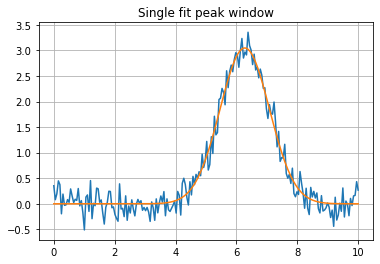

In [56]:
#Example 2

# Create a simple spectrum with a Gaussian.
np.random.seed(0)
x = np.linspace(0., 10., 200)
y = 3 * np.exp(-0.5 * (x- 6.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

# Create the spectrum
spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

# Fit the spectrum
g_init = models.Gaussian1D(amplitude=3.*u.Jy, mean=5.5*u.um, stddev=1.*u.um)
g_fit = fit_lines(spectrum, g_init, window=2*u.um)
y_fit = g_fit(x*u.um)

plt.plot(x, y)
plt.plot(x, y_fit)
plt.title('Single fit peak window')
plt.grid(True)

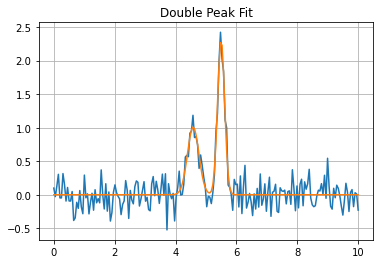

In [57]:
#Example 3
#Double Peak Fitting


# Create a simple spectrum with a Gaussian.
np.random.seed(42)

g1 = models.Gaussian1D(1, 4.6, 0.2)
g2 = models.Gaussian1D(2.5, 5.5, 0.1)
x = np.linspace(0, 10, 200)
y = g1(x) + g2(x) + np.random.normal(0., 0.2, x.shape)

# Create the spectrum to fit
spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

# Fit the spectrum
g1_init = models.Gaussian1D(amplitude=2.3*u.Jy, mean=5.6*u.um, stddev=0.1*u.um)
g2_init = models.Gaussian1D(amplitude=1.*u.Jy, mean=4.4*u.um, stddev=0.1*u.um)
g12_fit = fit_lines(spectrum, g1_init+g2_init)
y_fit = g12_fit(x*u.um)

plt.plot(x, y)
plt.plot(x, y_fit)
plt.title('Double Peak Fit')
plt.grid(True)